In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot, rcParams, animation, gridspec
from JSAnimation.IPython_display import display_animation

%matplotlib inline

In [2]:
class Panel:
    def __init__(self, xa, ya, xb, yb, gamma):
        #Start and end points
        self.xa, self.xb = xa, xb
        self.ya, self.yb = ya, yb
        
        #Center and length
        self.xc, self.yc = 0.5*(xa+xb), 0.5*(ya+yb)
        self.length = math.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        #Define Vortex point
        self.xvor = xa + 0.25*(xb-xa)
        self.yvor = ya + 0.25*(yb-ya)
        
        #Define velocity collocation point
        self.xvc = xa + 0.75*(xb-xa)
        self.yvc = ya + 0.75*(yb-ya)
        
        #Panel strength
        self.gamma = gamma
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.vt = 0.0; self.vn = 0.0
        self.cp = 0.0

In [3]:
class Vortex:
    def __init__(self, xvor, yvor, gamma):
    
        #Define eye of vortex
        self.xvor = xvor
        self.yvor = yvor

        #Define strength
        self.gamma = gamma

In [4]:
def get_vortex_panel_velocity(Xg, Yg, p):
    
    #x_p =  math.sin(p.beta)*(Xg-p.xb) - math.cos(p.beta)*(Yg-p.yb)
    #y_p =  math.cos(p.beta)*(Xg-p.xb) + math.sin(p.beta)*(Yg-p.yb)
    
    r2 = (Xg-p.xvor)**2 + (Yg-p.yvor)**2
    
    u_p = p.gamma/(2.0*math.pi*r2)*(Yg-p.yvor)
    v_p = -p.gamma/(2.0*math.pi*r2)*(Xg-p.xvor)
    
    #u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    #v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u_p, v_p

In [5]:
def create_camber_line(xc, c, p, m):
    
    if (xc >= 0.0 and xc <= p*c):
        yc = m*xc/p**2*(2.0*p - xc/c)
    elif (xc >= p*c and xc <= c):
        yc = m*(c-xc)/(1-p)**2*(1.0 - 2.0*p + xc/c)
    
    return(yc)

In [6]:
def translate_airfoil(p, u, v, delt):
    Np = numpy.size(p)
    
    for ip in range(Np):
        p[ip].xa += u*delt; p[ip].xb += u*delt; p[ip].xc += u*delt
        p[ip].xvc += u*delt; p[ip].xvor += u*delt

        p[ip].ya += v*delt; p[ip].yb += v*delt; p[ip].yc += v*delt
        p[ip].yvc += v*delt; p[ip].yvor += v*delt

In [7]:
def pitch_plunge_airfoil(p, amp, omega, time, angmax):
    Np = numpy.size(p)
    
    xcent0 = 0.25;
    ch_len = 1.0
    xcent = p[0].xa + 0.25*(p[-1].xb-p[0].xa)
    ycent0 = create_camber_line(xcent0, ch_len, 0.5, 0.02)
    
    ycent = ycent0 + amp*numpy.sin(omega*time)
    
    ang = numpy.radians(angmax)*numpy.sin(omega*time)
    
    for ip in range(Np):
        #Update positions of end points:
        p[ip].ya += amp*numpy.sin(omega*time)
        p[ip].yb += amp*numpy.sin(omega*time)
        
        p[ip].xa, p[ip].ya = rotate_coord(p[ip].xa, \
                  p[ip].ya, xcent, ycent, -1.0*ang)
        
        #Update positions of center points:
        p[ip].xc = p[ip].xa + 0.5*(p[ip].xb - p[ip].xa)
        p[ip].yc = p[ip].ya + 0.5*(p[ip].yb - p[ip].ya)
        
        #Update positions of vortex points:
        p[ip].xvor = p[ip].xa + 0.25*(p[ip].xb - p[ip].xa)
        p[ip].yvor = p[ip].ya + 0.25*(p[ip].yb - p[ip].ya)
        
        #Update positions of center points:
        p[ip].xvc = p[ip].xa + 0.75*(p[ip].xb - p[ip].xa)
        p[ip].yvc = p[ip].ya + 0.75*(p[ip].yb - p[ip].ya)

In [8]:
def animate(data):
    x = data[:,0]
    y = data[:,1]
    line.set_data(x,y)
    return line,

In [9]:
def rotate_coord(xco, yco, x0, y0, angle):
    xnew = (xco-x0)*numpy.cos(angle) - (yco-y0)*numpy.sin(angle)
    ynew = (xco-x0)*numpy.sin(angle) + (yco-y0)*numpy.cos(angle)
    return (xnew+x0, ynew+y0)

In [10]:
def get_panel_influence(p):
    Np = numpy.size(p)
    Amat = numpy.zeros((Np,Np)); bmat = numpy.zeros(Np)
    
    for ip in range(Np):
        xp = p[ip].xvc; yp = p[ip].yvc; gam = p[ip].gamma
        for jp in range (Np):
            xvel, yvel = get_vortex_panel_velocity(xp, yp, p[jp])
            Amat[ip,jp] = numpy.dot([xvel, yvel], p[ip].n);
        
    return(Amat)

In [11]:
def get_RHS0(p, ufs, vfs):
    xp = p.xvc; yp = p.yvc; gam = p.gamma; RHS = 0.0
    RHS -= numpy.dot([ufs, vfs], p.n)
    return(RHS)

In [12]:
def get_RHS(p, vortex, ufs, vfs):
    Nv = numpy.size(vortex)
    #print('Nv', Nv)
    xp = p.xvc; yp = p.yvc; gam = p.gamma; RHS = 0.0
    for iv in range(Nv):
        xvel, yvel = get_vortex_panel_velocity(xp, yp, vortex[iv])
        RHS -= numpy.dot([xvel, yvel], p.n)
            
    RHS -= numpy.dot([ufs, vfs], p.n)
        
    return(RHS)

In [13]:
def get_wvortex_influence(p, vortex):
    Np = numpy.size(p)
    Amat = numpy.zeros(Np); 
    
    for ip in range(Np):
        xp = p[ip].xvc; yp = p[ip].yvc; gam = p[ip].gamma
        xvel, yvel = get_vortex_panel_velocity(xp, yp, vortex)
        
        Amat[ip] = numpy.dot([xvel, yvel], p[ip].n);
        
    return(Amat)

In [14]:
def reset_panel_strengths(p):
    Np = numpy.size(p)
    for ip in range (Np):
        p[ip].gamma = 1.0

In [15]:
def update_contour_plot(i, ax1, ax2, fig, x, y, ui, vi, z1, x2, z2, pan):
    '''
    Note that in `FuncAnimation` above, we only pass in 
    `ax`, `fig`, and `x` (the `fargs`) but that `update_contour_plot`
    takes a fourth argument `i`.  This argument is sent by the
    animation routine automatically and is incremented by 1 each
    time while i < # of frames
    '''
    #-----------------------------------------------------------------------------#
    ax1.cla()                #clear the existing contour plot
    im = ax1.contourf(x, y, z1[i], \
    levels=numpy.linspace(0.,3.0,20), extend='both')  #update the contour plot with the new data
    #ax1.figure.set_figheight(6); ax1.figure.set_figwidth(10)
    ax1.streamplot(X,Y,ui[i],vi[i], color='#000000')
    ax1.plot(pan[i,:,0], pan[i,:,1], color='#FF0000', lw=2)
    ax1.set_title('Contours of velocity magnitude and streamlines', fontsize=16)
    #-----------------------------------------------------------------------------#
    
    
    #-----------------------------------------------------------------------------#
    ax2.cla()
    #ax2.figure.set_figheight(6); ax1.figure.set_figwidth(6)
    ax2.set_title('Line plot of pressure coefficient', fontsize=16)
    ax2.set_ylim(-0.2, 0.0)
    ax2.grid(True)
    pl = ax2.plot(x2, z2[i])
    #-----------------------------------------------------------------------------#
    
    return ax, im, pl,           #return the new contour plot object 
    #Note the comma, that's required.


In [16]:
def create_contour_animation(ITERCOUNT, x, y, data1, data2, data3, data4, pan):
    z1 = []; z2 = [];
    ui = []; vi = []
    n = ITERCOUNT
    #calculate all of the data to shown in the contour plot and
    #append it all to a list `x`
    for i in range(n):
        ui.append(data1[i,:,:])
        vi.append(data2[i,:,:])
        z1.append(data3[i,:,:])
        z2.append(data4[i,:])
        
    Np = numpy.size(data4[0,:]);
    x2 = numpy.linspace(0,1,Np)
        
    #create a figure and add the initial plot of the animation
    fig = pyplot.figure(figsize=(16,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    
    #-----------------------------------------------------------------------------#
    im = pyplot.contourf(x, y, z1[0],\
        levels=numpy.linspace(0.,3.0,20), extend='both')
    
    ax1 = pyplot.subplot(gs[0])
    #ax1 = fig.gca()
    #ax1.figure.set_figheight(6); ax1.figure.set_figwidth(10)
    ax1.set_title('Contours of velocity magnitude and streamlines', fontsize=16)
    
    ax1.streamplot(x, y, ui[0], vi[0], color='#000000')
    ax1.plot(pan[0,:,0], pan[0,:,1], color='#FF0000', lw=2)
    cbar = ax1.figure.colorbar(im)
    #-----------------------------------------------------------------------------#
    
    
    #-----------------------------------------------------------------------------#
    ax2 = pyplot.subplot(gs[1])
    pl = pyplot.plot(x2, z2[0])
    #ax2 = fig.gca()
    #ax2.figure.set_figheight(6); ax1.figure.set_figwidth(6)
    ax2.set_title('Line plot of pressure coefficient', fontsize=16)
    ax2.set_ylim(-0.2, 0.0)
    ax2.grid(True)
    pyplot.grid(True)
    #-----------------------------------------------------------------------------#
    
    pyplot.tight_layout()
    ani = animation.FuncAnimation(fig, update_contour_plot, frames=n, 
                                  fargs=(ax1, ax2, fig, x, y, ui, vi, z1, x2, z2, pan), interval=100)
    
    
    return ani                           

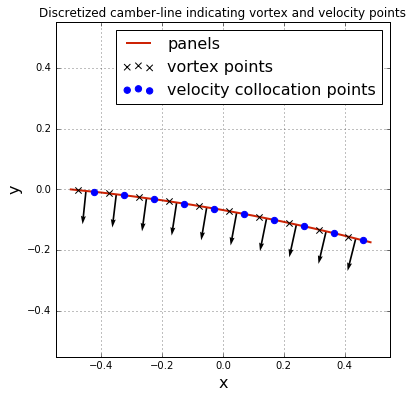

In [17]:
#Airfoil NACA 2510

c = 1.0; m = 0.02; p = 0.5
N_panels = 10

xends1 = numpy.linspace(0.0, 1.0, N_panels + 1);
xends = xends1 - 0.5
yends = numpy.zeros_like(xends)

for ip in range(N_panels+1):
    yends[ip] = create_camber_line(xends1[ip], c, p, m);

for ip in range(N_panels+1):
    xends[ip], yends[ip] = rotate_coord(xends[ip], yends[ip],\
                        xends[0], yends[0], numpy.radians(-10))

panels = numpy.empty(N_panels, dtype='object')

for ip in range (N_panels):
    panels[ip] = Panel(xends[ip], yends[ip], xends[ip+1], yends[ip+1], 1.0)
    
    
pyplot.figure(figsize=(6,6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-0.55,0.55)
pyplot.ylim(-0.55,0.55)
pyplot.grid(True)

pyplot.plot(xends, yends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xvor for p in panels], [p.yvor for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.scatter([p.xvc for p in panels], [p.yvc for p in panels], color='#0000FF', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=10, width=0.005)

pyplot.title('Discretized camber-line indicating vortex and velocity points')
pyplot.legend(['panels', 'vortex points', 'velocity collocation points'], loc='best', prop={'size':16})    


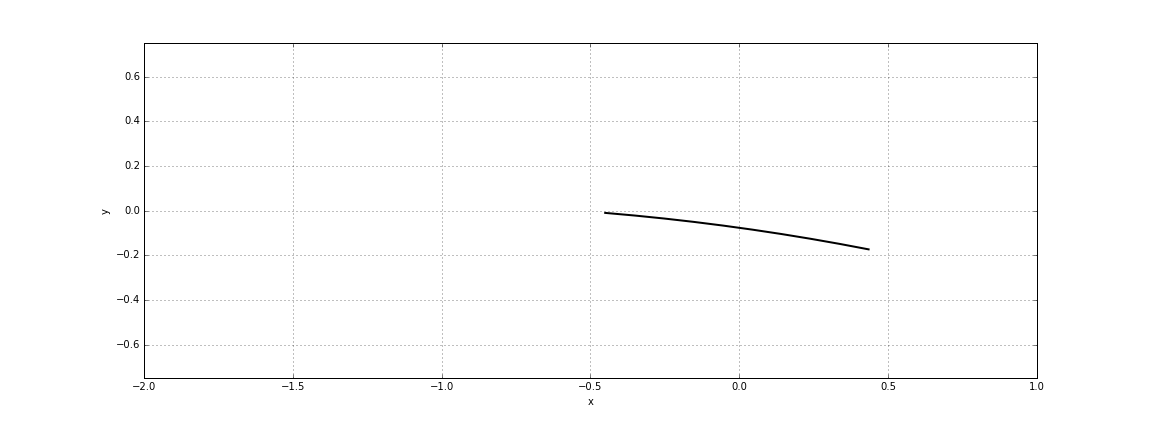
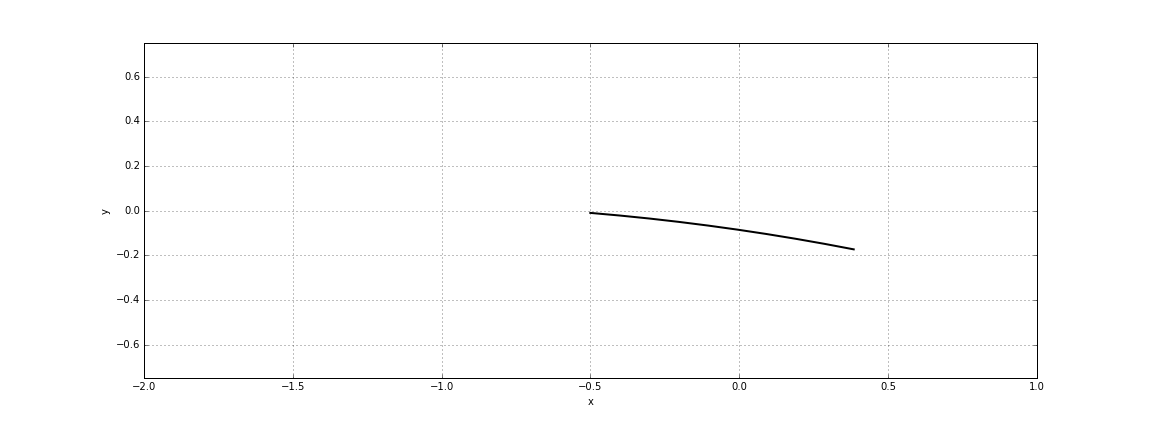
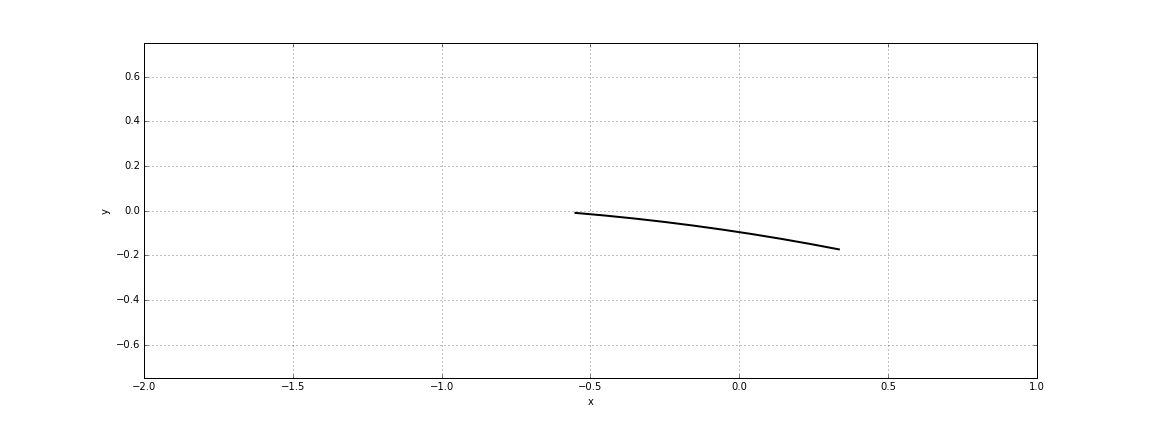
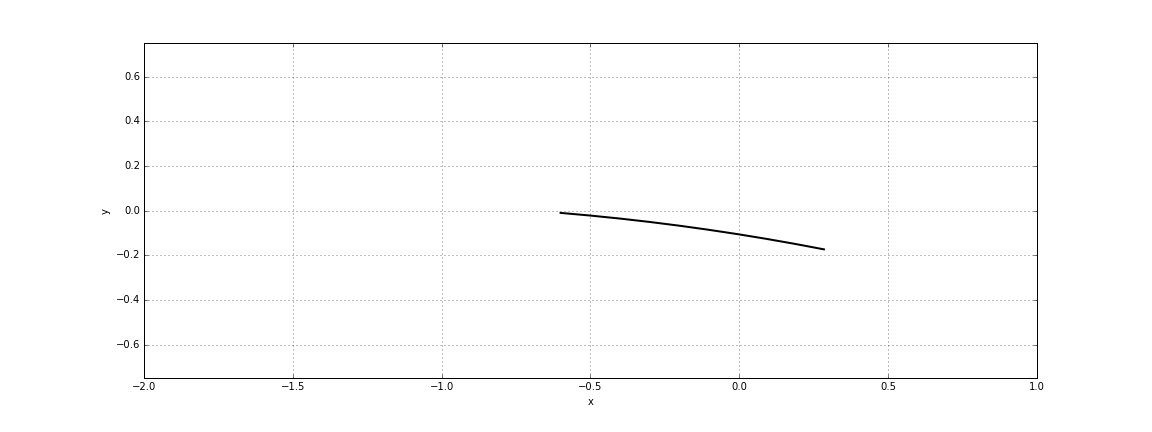
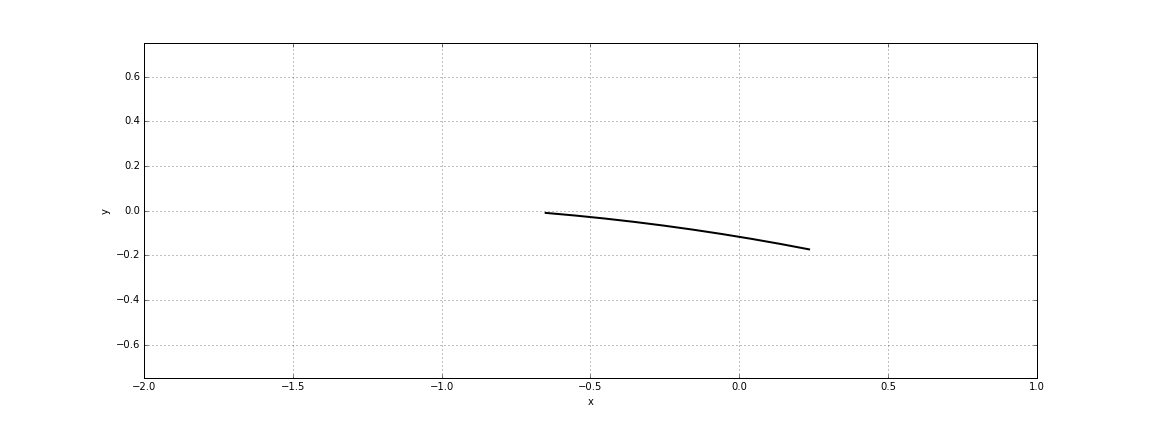
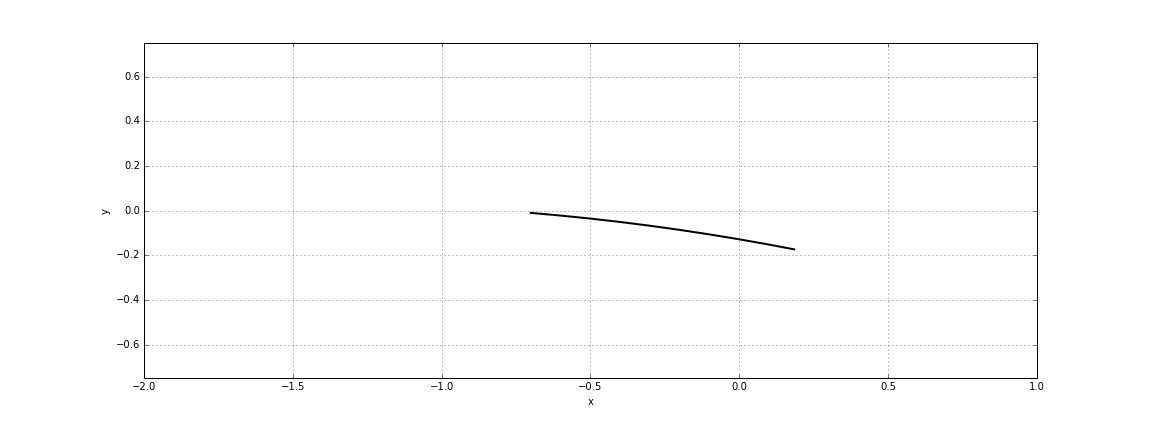
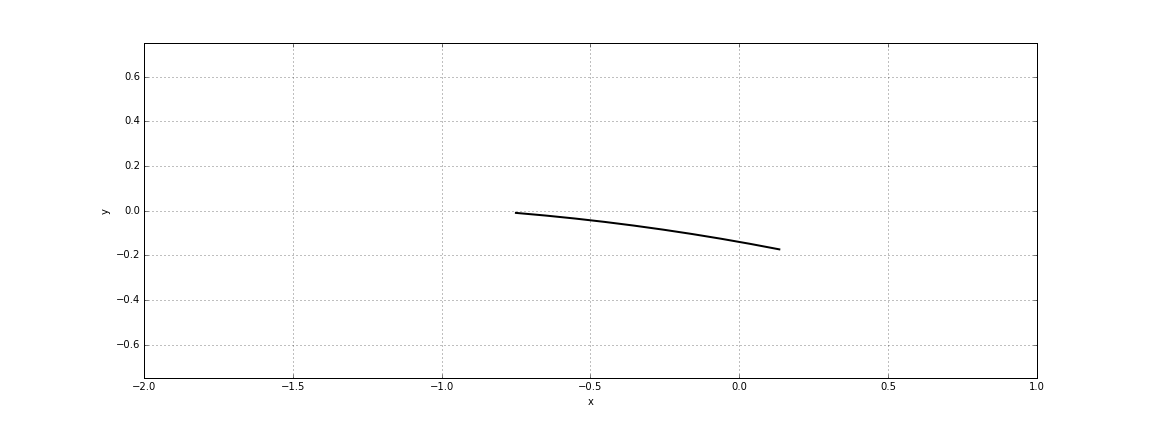
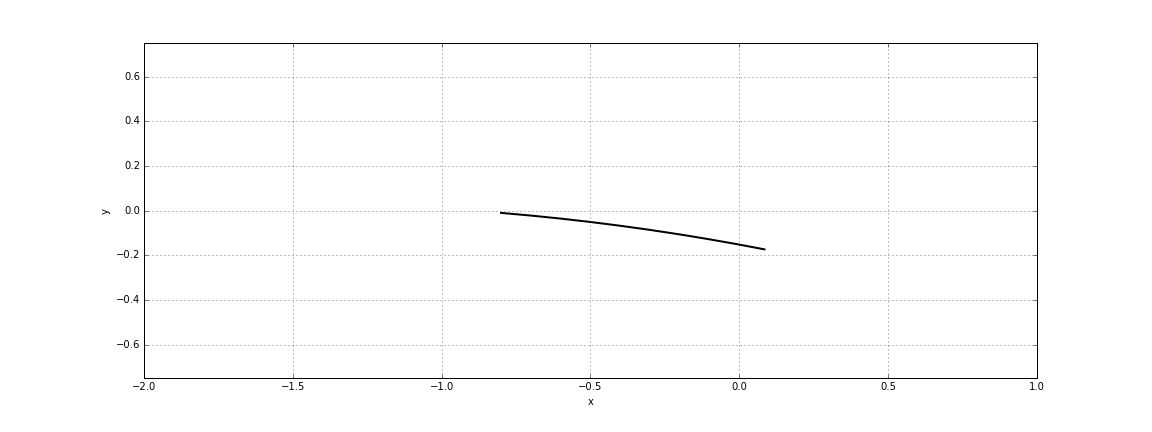
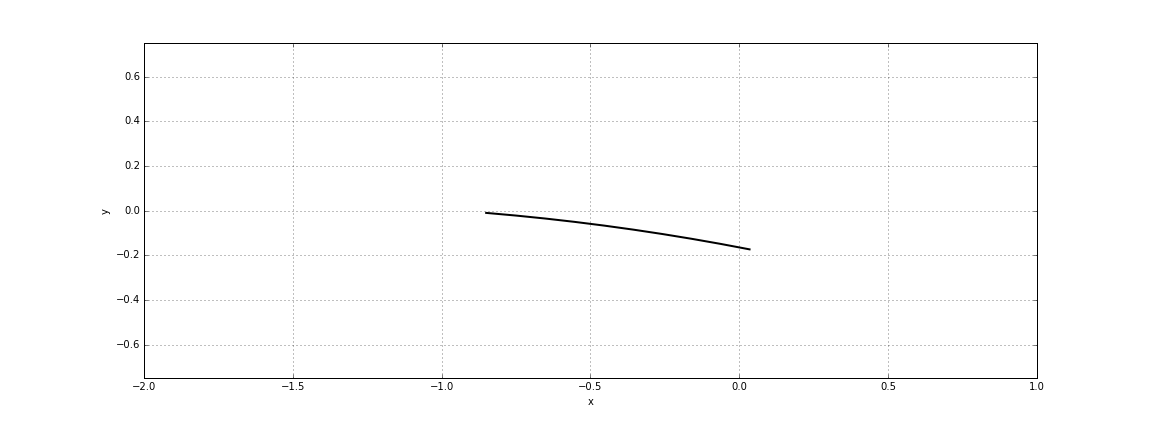
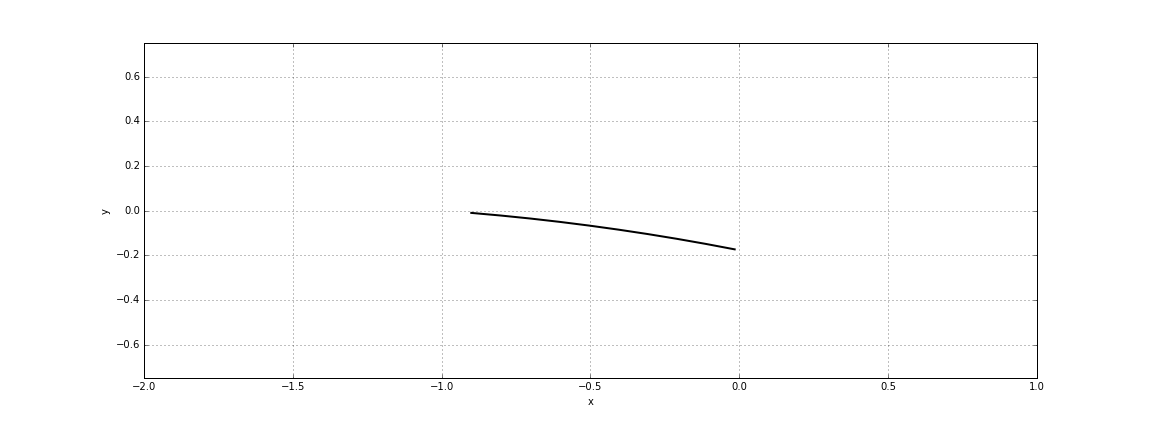
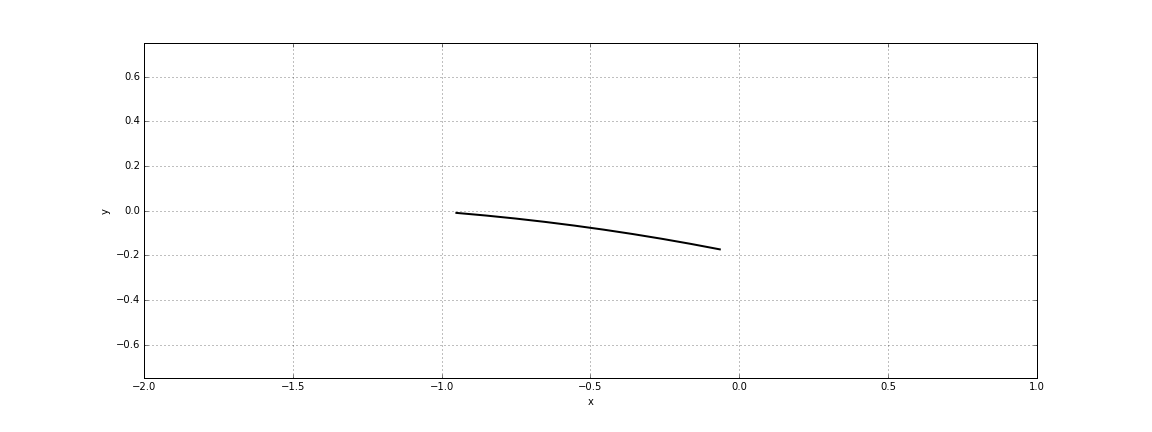
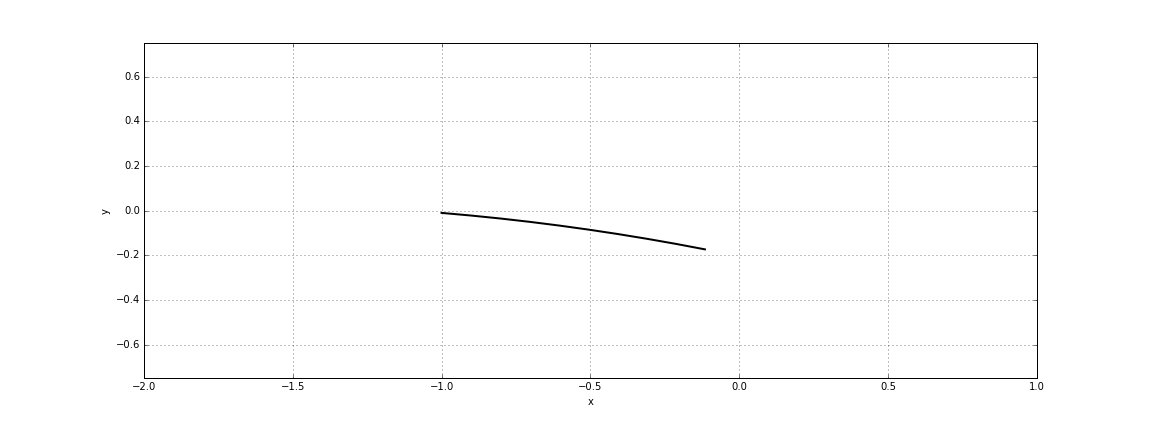
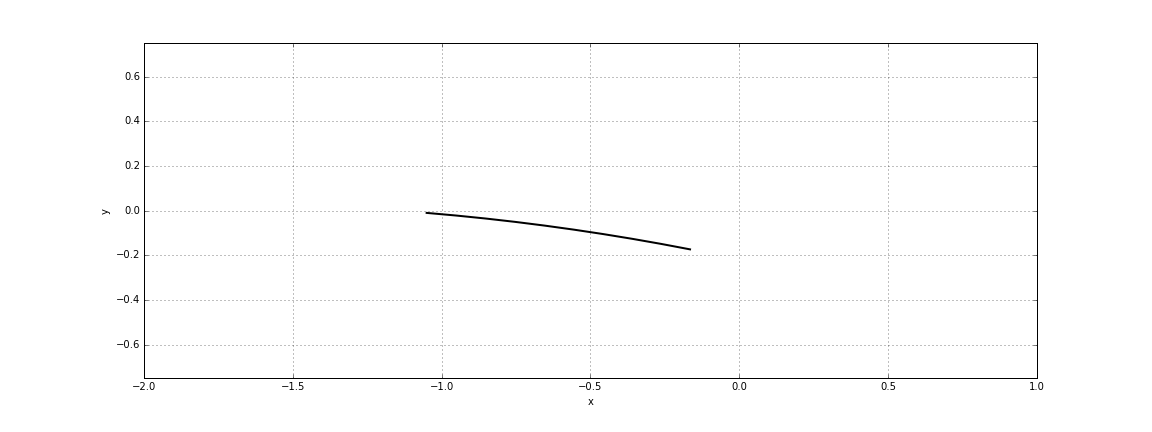
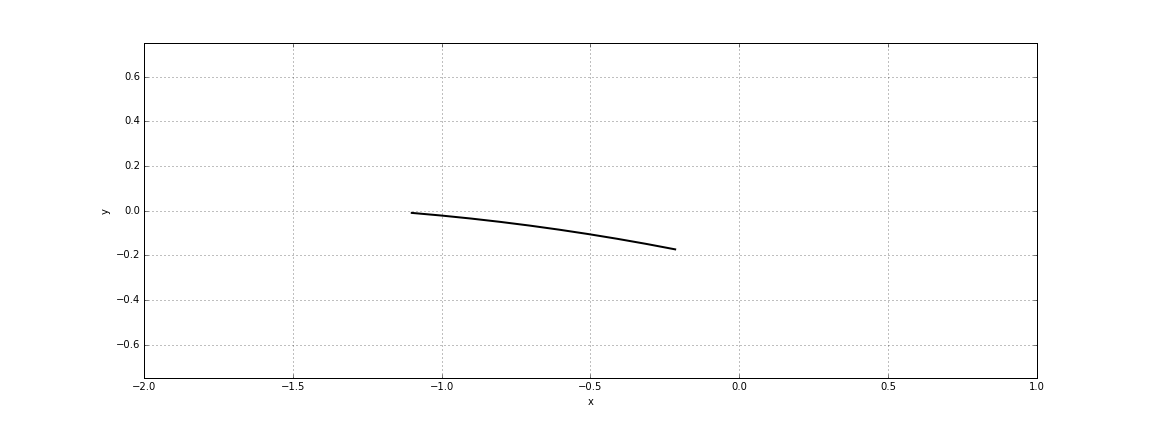
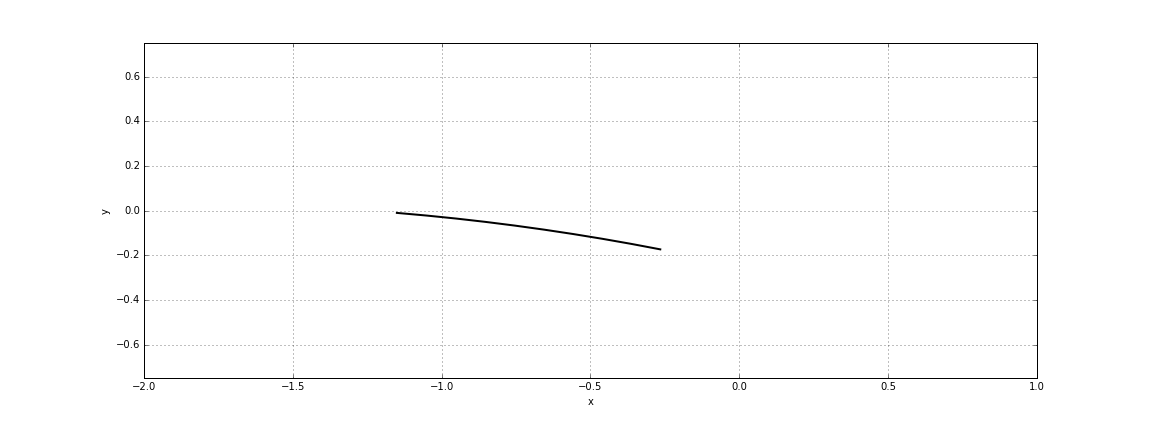
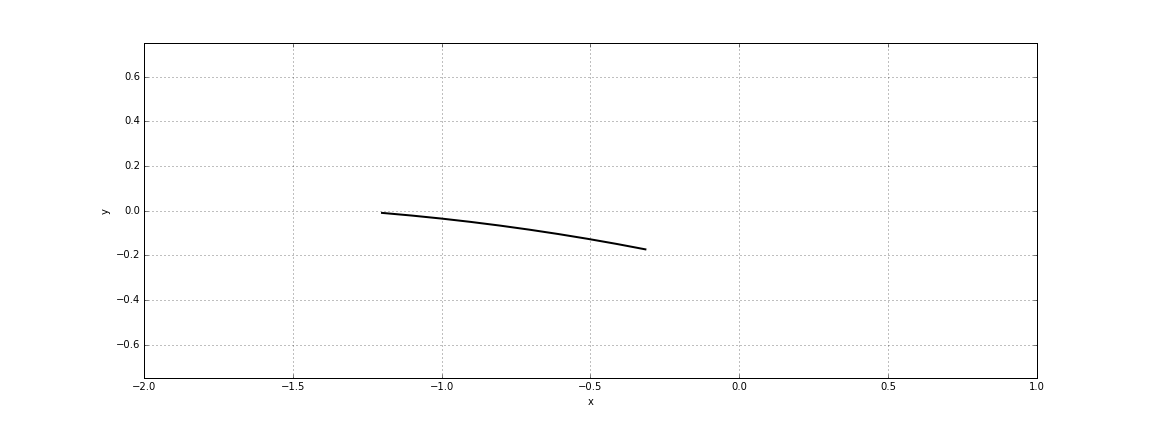
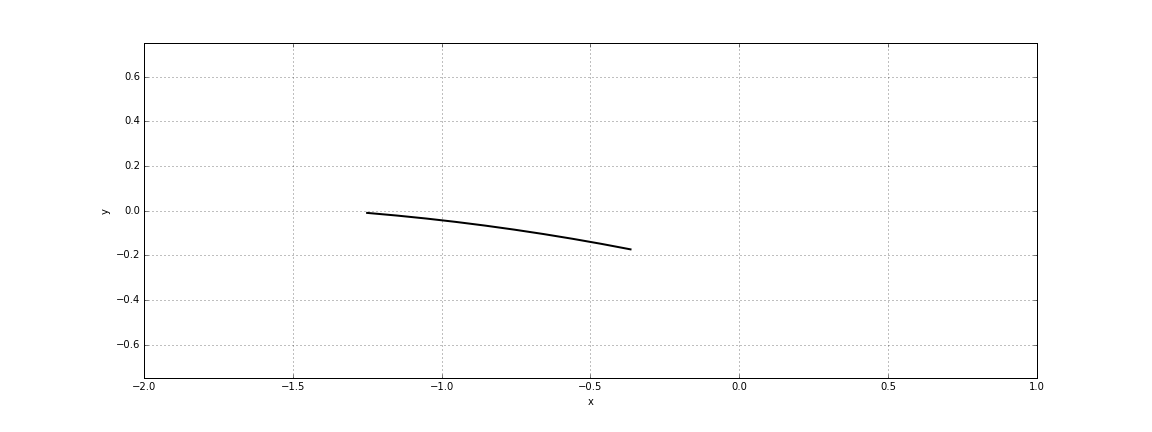
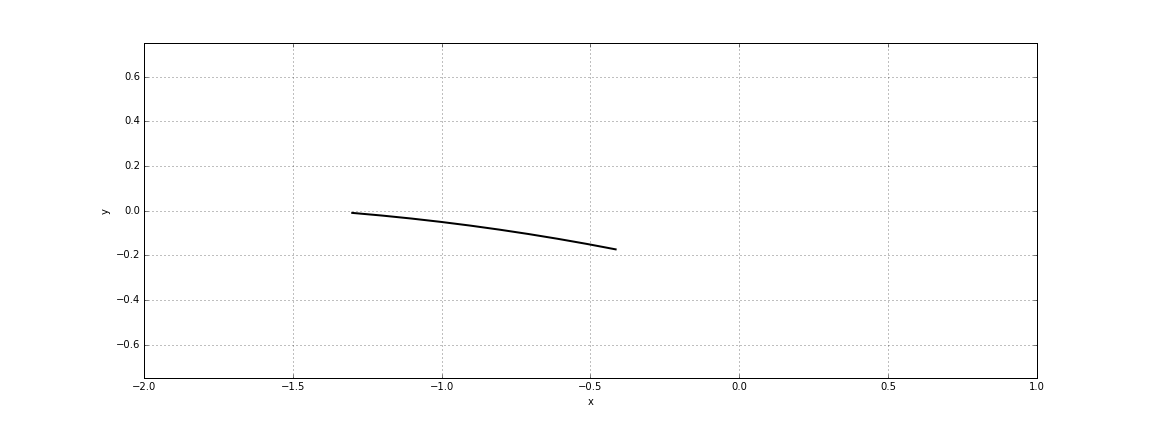
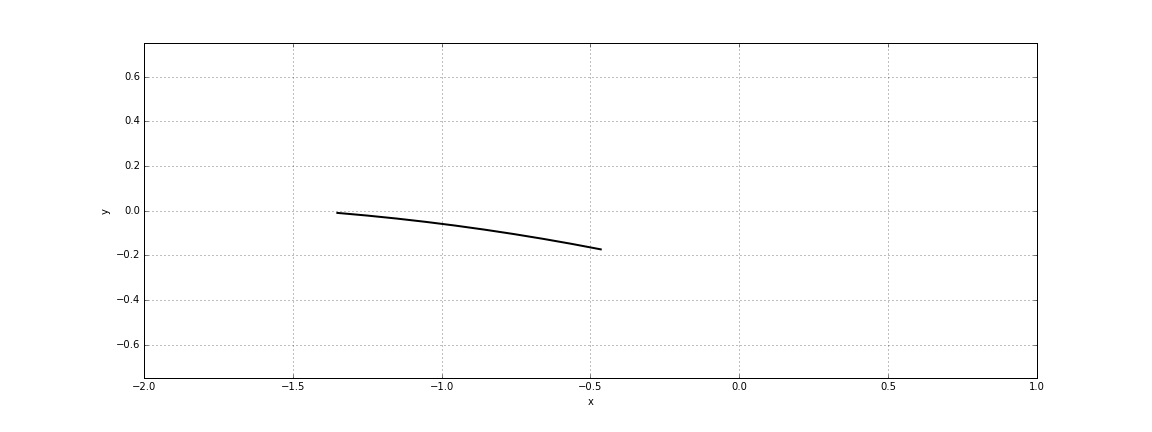
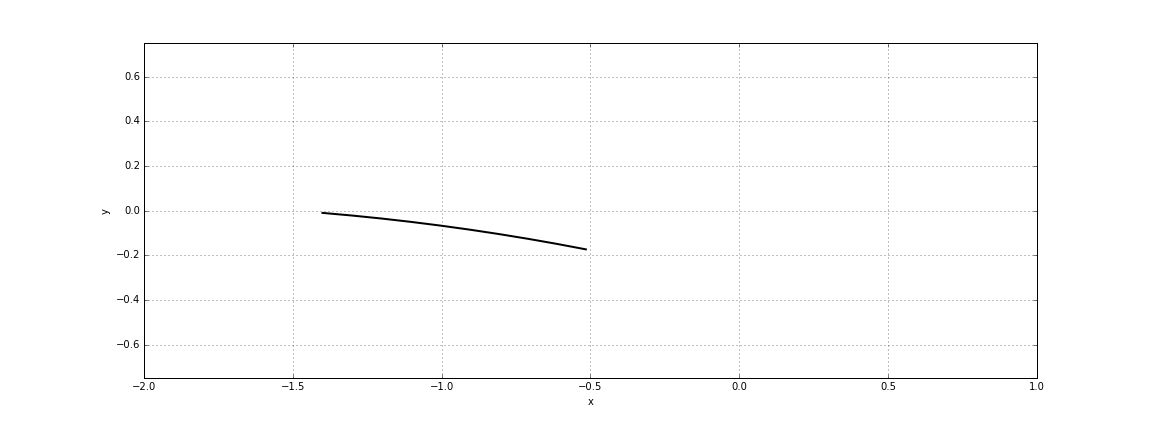

In [18]:
reset_panel_strengths(panels)

ITERMAX = 20; dt = 0.05
t0 = 0.0; tmax = t0 + ITERMAX*dt
time = t0

upanel = 1.0*numpy.cos(numpy.radians(180))
vpanel = 1.0*numpy.sin(numpy.radians(180))

plot_data = numpy.zeros((ITERMAX,N_panels,2))
plot_wvor = numpy.zeros((ITERMAX+1,2))

wvor = numpy.empty(ITERMAX+1,dtype='object')
#----------------------------------------------------------#


#----------------------------------------------------------#
N = 101
x_start, x_end = -2.0, 0.75              # boundaries in the x-direction
y_start, y_end = -0.75, 0.75               # boundaries in the y-direction
x = numpy.linspace(x_start, x_end, N)    # creates a 1D-array with the x-coordinates
y = numpy.linspace(y_start, y_end, N)    # creates a 1D-array with the y-coordinates
X, Y = numpy.meshgrid(x, y)              # generates a mesh grid

uplot = numpy.zeros((ITERMAX,N,N))
vplot = numpy.zeros((ITERMAX,N,N))

plot_panels = numpy.zeros((ITERMAX,N_panels,2))
plot_Cp_data = numpy.zeros((ITERMAX,N_panels))
plot_Len = numpy.linspace(panels[0].xvc, panels[-1].xvc, N_panels)
plot_Len += 0.5
#----------------------------------------------------------#


#----------------------------------------------------------#
#Pitch-plunge related
amp = 0.1;
omega = 2.0*math.pi/tmax
ang_max = 10
#----------------------------------------------------------#


#----------------------------------------------------------#
A0 = numpy.zeros((N_panels,N_panels))
b0 = numpy.zeros(N_panels)

A = numpy.zeros((N_panels+1, N_panels+1)); 
b = numpy.zeros(N_panels+1)
#----------------------------------------------------------#


#----------------------------------------------------------#
A0 = get_panel_influence(panels)
for ip in range(N_panels):
    b0[ip] = get_RHS0(panels[ip], -1.0*upanel, -1.0*vpanel)

xgam0 = numpy.linalg.solve(A0,b0)
xgam_n = numpy.copy(xgam0)

sum_gam = 0.0
for ip in range(N_panels):
    sum_gam += xgam_n[ip]
    
wvor[0] = Vortex(panels[-1].xb, panels[-1].yb, -1.0*sum_gam) 
plot_wvor[0,0] = panels[-1].xb
plot_wvor[0,1] = panels[-1].yb

A[:-1,:-1] = numpy.copy(A0)
#----------------------------------------------------------#


#----------------------------------------------------------#
ic_vor = 1
for iter in range(ITERMAX):
    
    xbend = panels[-1].xb; ybend = panels[-1].yb
    
    #----------------------------------------------------------#
    #Kinematics
    translate_airfoil(panels, upanel, vpanel, dt)
    #pitch_plunge_airfoil(panels, amp, omega, time, ang_max)
    
    for ip in range(N_panels):
        plot_data[iter, ip, 0] = panels[ip].xb
        plot_data[iter, ip, 1] = panels[ip].yb
    
    #----------------------------------------------------------#
    #Add Wake vortex  
    dispx = panels[-1].xb - xbend        
    dispy = panels[-1].yb - ybend        
    
    #----------------------------------------------------------#
    #Create new vortex location
    xlocv = panels[-1].xb - 0.75*dispx
    ylocv = panels[-1].yb - 0.75*dispy
    
    plot_wvor[ic_vor,0] = xlocv
    plot_wvor[ic_vor,1] = ylocv
    
    #----------------------------------------------------------#
    #Create vortex object
    wvor[ic_vor] = Vortex(xlocv, ylocv, 1.0)
     
    #----------------------------------------------------------#
    #Create linear algebra system
    A[:-1,-1] = get_wvortex_influence(panels, wvor[ic_vor])
    A[-1,:] = numpy.ones(N_panels+1);
    
    for ip in range(N_panels):
        if (iter == 0):
            b[ip] = numpy.copy(b0[ip])
        else:
            b[ip] = get_RHS(panels[ip], wvor[:ic_vor], -1.0*upanel, -1.0*vpanel)
    
    sum_gam = 0.0
    
    for jp in range(N_panels):
        sum_gam += xgam_n[jp]
            
    b[-1] = sum_gam
    
    #----------------------------------------------------------#       
    #Solve system of equations
    xgam_n = numpy.linalg.solve(A,b)
    
    for ip in range (N_panels):
        plot_panels[iter,ip,0] = panels[ip].xvor
        plot_panels[iter,ip,1] = panels[ip].yvor
        panels[ip].gamma = xgam_n[ip]
        panels[ip].vt = 0.0; panels[ip].vn = 0.0; 
        panels[ip].cp = 0.0
    
    wvor[ic_vor].gamma = xgam_n[-1]
    
    ic_vor += 1; time += dt    
    
    #----------------------------------------------------------#
    #Create flow fields
    for i in range(N):
        for j in range(N):
            for ip in range (N_panels):
                xp = panels[ip].xvc; 
                yp = panels[ip].yvc; 
                gam = panels[ip].gamma

                velx, vely = get_vortex_panel_velocity(X[i,j], Y[i,j], \
                                                       panels[ip])
                uplot[iter,i,j] += velx; vplot[iter,i,j] += vely

            for ivor in range(ic_vor):
                #print(iter, wvor[ivor].gamma)
                velx, vely = get_vortex_panel_velocity(X[i,j], Y[i,j], \
                                                       wvor[ivor])
                uplot[iter,i,j] += velx; vplot[iter,i,j] += vely
                
    uplot[iter,:,:] -= upanel; vplot[iter,:,:] -= vpanel
    
                
    #----------------------------------------------------------#
    #Compute Cp values
    for ip in range (N_panels):
        xp = panels[ip].xvc; 
        yp = panels[ip].yvc; 
        gam = panels[ip].gamma

        panels[ip].vt = 0.
        panels[ip].vn = 0.

        for jp in range (N_panels):
            xvel, yvel = get_vortex_panel_velocity(xp, yp, panels[jp])
            panels[ip].vt += numpy.dot([xvel, yvel], panels[ip].t)
            panels[ip].vn += numpy.dot([xvel, yvel], panels[ip].n)

        for ivor in range(iter):
            xvel, yvel = get_vortex_panel_velocity(xp, yp, wvor[ivor])
            panels[ip].vt += numpy.dot([xvel, yvel], panels[ip].t)
            panels[ip].vn += numpy.dot([xvel, yvel], panels[ip].n)

        panels[ip].vt += numpy.dot([upanel, vpanel], panels[ip].t)
        panels[ip].vn += numpy.dot([upanel, vpanel], panels[ip].n)
        #print(panels[ip].vn)

        panels[ip].cp = 1.0 - (panels[ip].vn**2 + panels[ip].vt**2)\
                                /(upanel**2+vpanel**2)
            
        plot_Cp_data[iter,ip] = panels[ip].cp
        #print(panels[ip].cp)
        
    
#----------------------------------------------------------#
#Animate airfoil motion
fig = pyplot.figure(figsize=(16,6));
ax = pyplot.axes(xlim=(-2.,1.),ylim=(-0.75,0.75),xlabel=('x'),ylabel=('y'));
ax.grid(True)
line, = ax.plot([],[],color='#000000', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=plot_data, interval=50)
display_animation(anim, default_mode='once')

In [19]:
u = numpy.zeros((N, N), dtype=float)
v = numpy.zeros((N, N), dtype=float)

for ip in range (N_panels):
    panels[ip].gamma = xgam_n[ip]
    panels[ip].vt = 0.0; panels[ip].vn = 0.0; panels[ip].cp = 0.0
    
for i in range (N):
    for j in range (N):
        for ip in range (N_panels):
            xp = panels[ip].xvc; 
            yp = panels[ip].yvc; 
            gam = panels[ip].gamma
           
            velx, vely = get_vortex_panel_velocity(X[i,j], Y[i,j], \
                                                   panels[ip])
            u[i,j] += velx; v[i,j] += vely
    
        for ivor in range(iter):
            #print(iter, wvor[ivor].gamma)
            velx, vely = get_vortex_panel_velocity(X[i,j], Y[i,j], \
                                                   wvor[ivor])
            u[i,j] += velx; v[i,j] += vely
            #print(velx, vely)
            
u -= upanel; v -= vpanel

for ip in range (N_panels):
    xp = panels[ip].xvc; 
    yp = panels[ip].yvc; 
    gam = panels[ip].gamma
    
    panels[ip].vt = 0.
    panels[ip].vn = 0.
    
    for jp in range (N_panels):
        xvel, yvel = get_vortex_panel_velocity(xp, yp, panels[jp])
        panels[ip].vt += numpy.dot([xvel, yvel], panels[ip].t)
        panels[ip].vn += numpy.dot([xvel, yvel], panels[ip].n)
        
    for ivor in range(ic_vor):
        xvel, yvel = get_vortex_panel_velocity(xp, yp, wvor[ivor])
        panels[ip].vt += numpy.dot([xvel, yvel], panels[ip].t)
        panels[ip].vn += numpy.dot([xvel, yvel], panels[ip].n)
        
    panels[ip].vt += numpy.dot([upanel, vpanel], panels[ip].t)
    panels[ip].vn += numpy.dot([upanel, vpanel], panels[ip].n)
    #print(panels[ip].vn)
    
    panels[ip].cp = 1.0 - (panels[ip].vn**2 + panels[ip].vt**2)\
                            /(upanel**2+vpanel**2)
#     print(panels[ip].cp)
    
#print(wvor[iter].gamma)

(-0.75, 0.75)

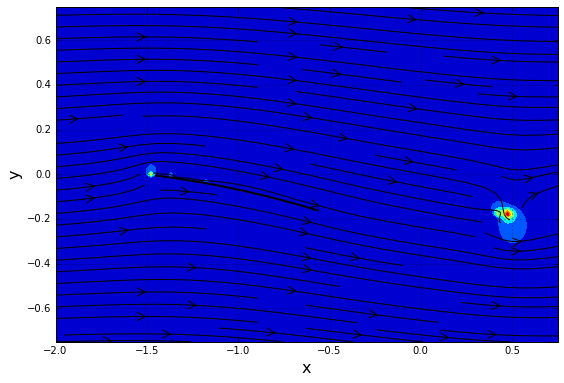

In [20]:
pyplot.figure(figsize=(9, 6))

# pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.contourf(X, Y, numpy.sqrt(u**2+v**2))#, levels=numpy.linspace(0,2.0,50), extend='both')
pyplot.plot([p.xc for p in panels], [p.yc for p in panels], \
            color='#000000', linestyle='-', linewidth=2)
pyplot.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=2, arrowstyle='->', color='#000000')
#pyplot.xlim(x_start, x_end)
#pyplot.ylim(y_start, y_end);
pyplot.xlim(-2, 0.75)
pyplot.ylim(-0.75,0.75);


# pyplot.subplot(122)
# pyplot.plot([p.xvc for p in panels], [p.cp for p in panels])
# #pyplot.xlim(-0.5, 0.5)
# pyplot.grid(True)

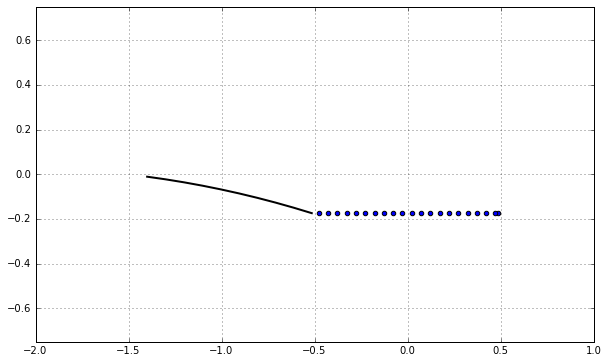

In [21]:
pyplot.figure(figsize=(10,6))
pyplot.xlim(-2.0, 1.0)
pyplot.ylim(-0.75, 0.75)
pyplot.grid(True)
pyplot.plot([p.xb for p in panels],[p.yb for p in panels],color='#000000', lw=2)
pyplot.scatter(plot_wvor[:,0], plot_wvor[:,1])


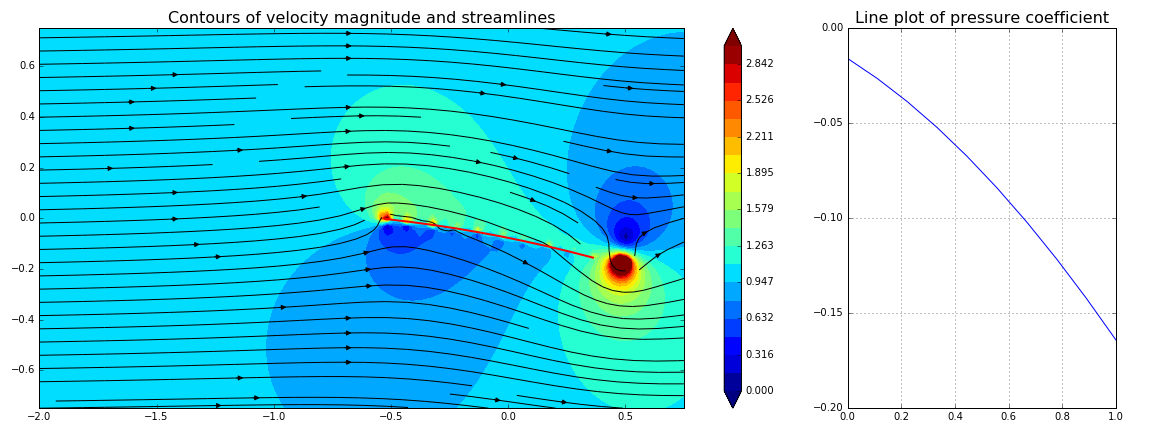
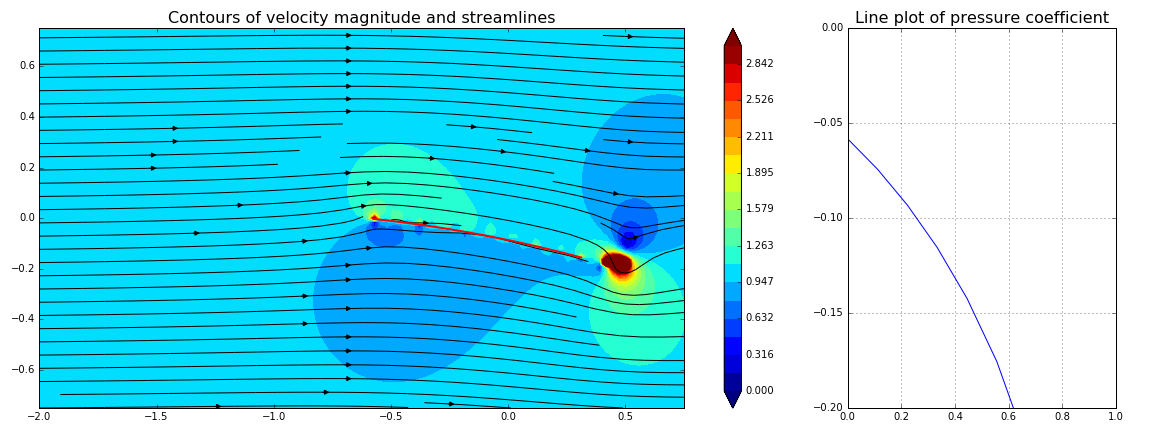
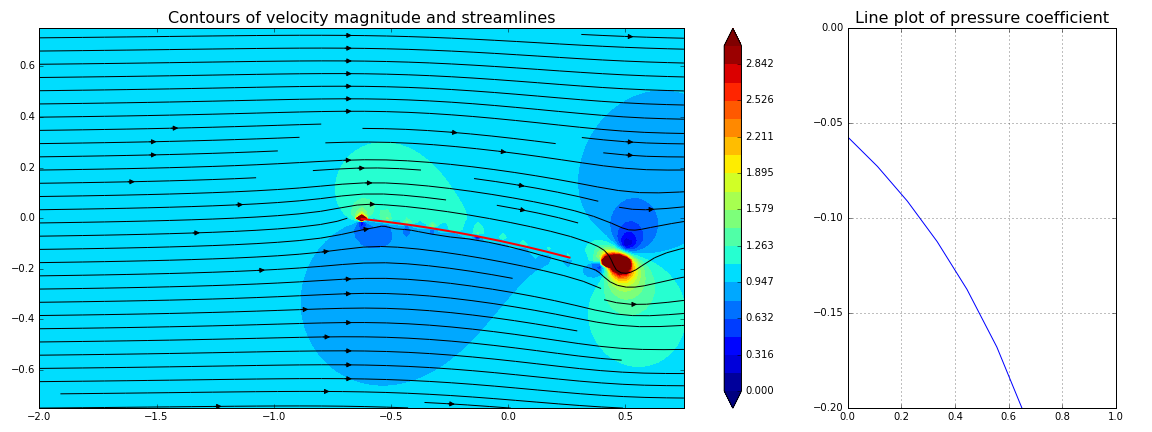
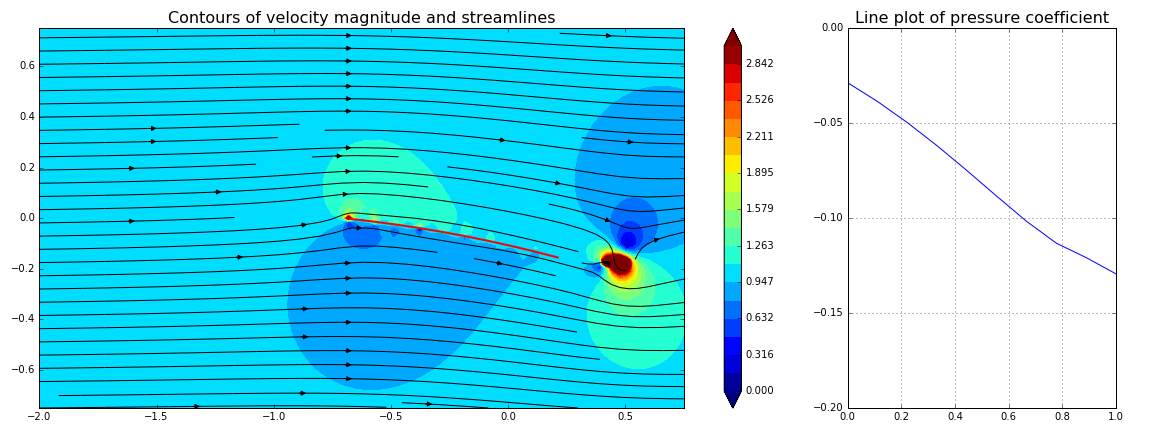
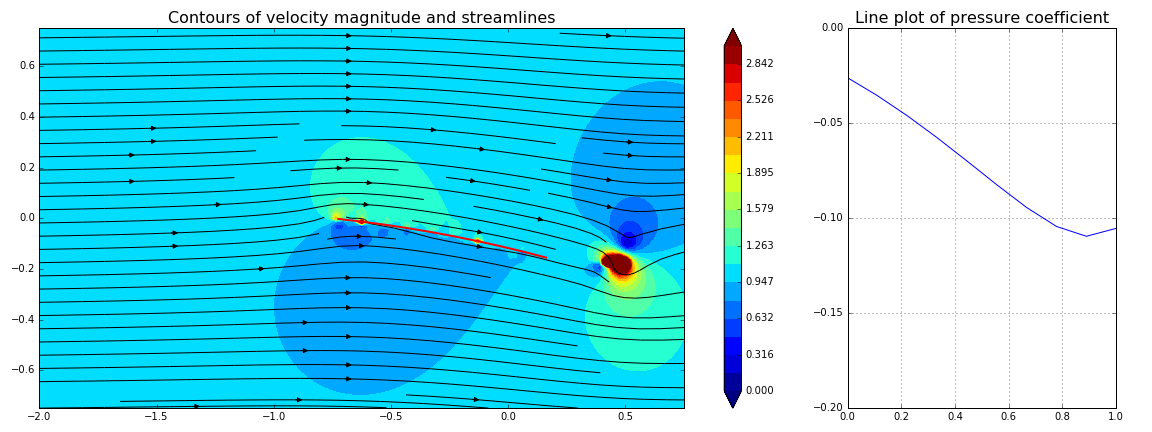
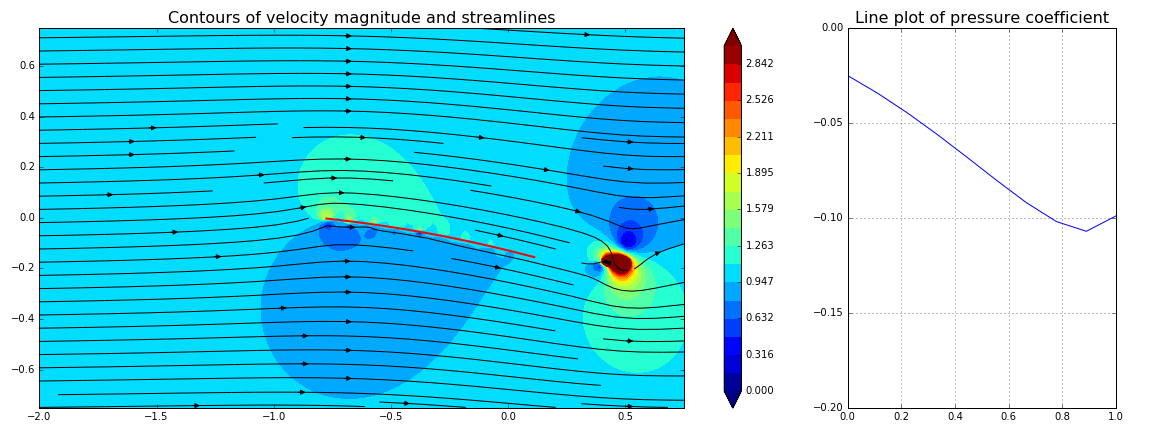
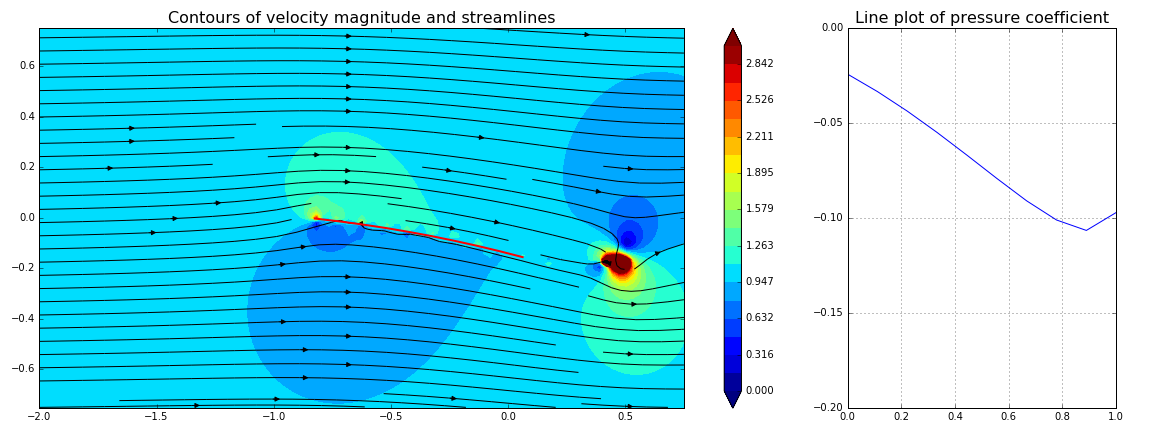
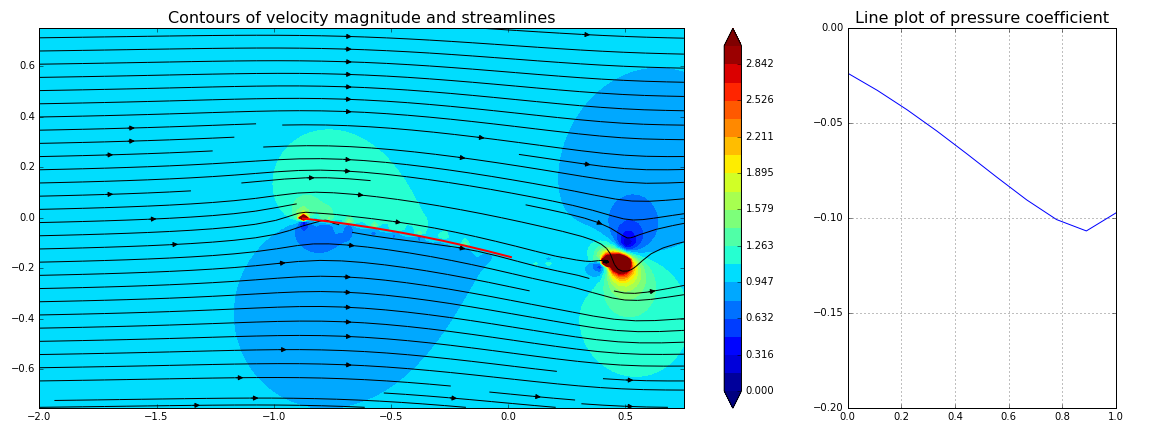
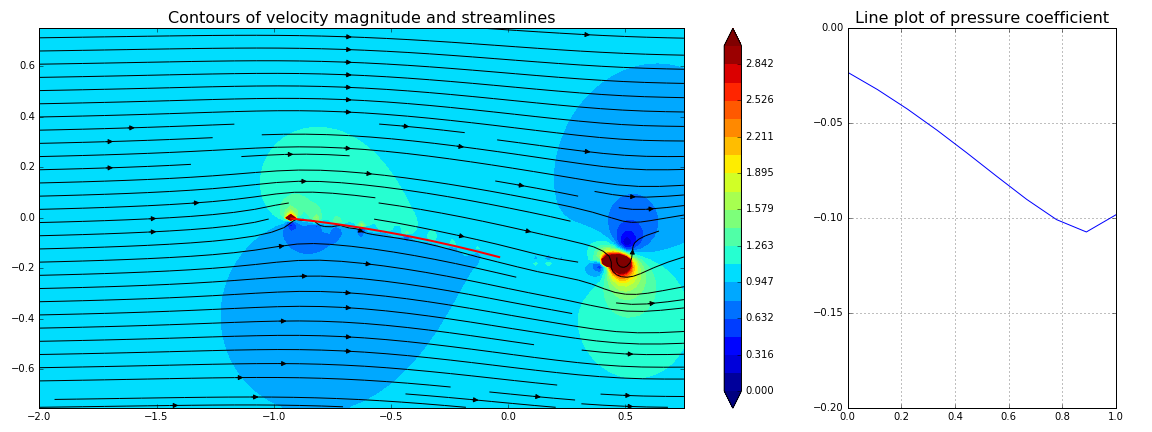
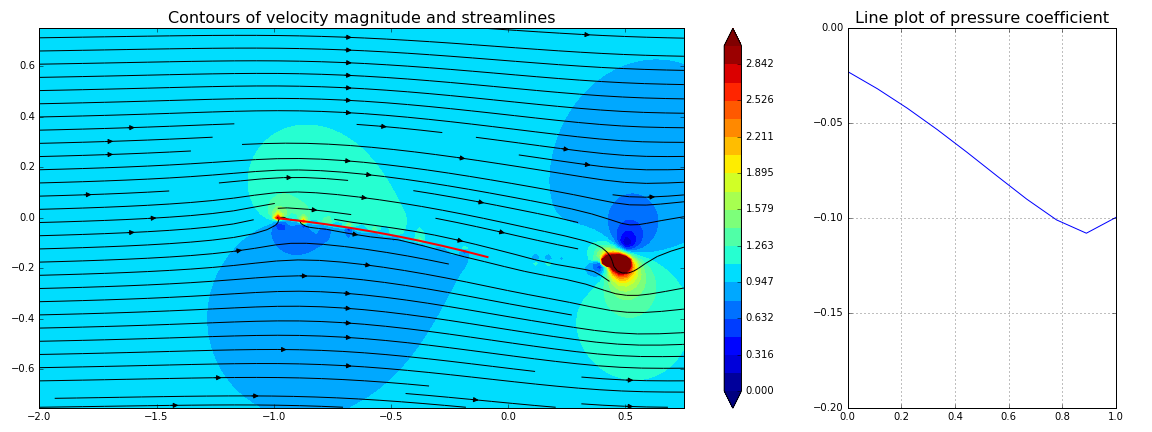
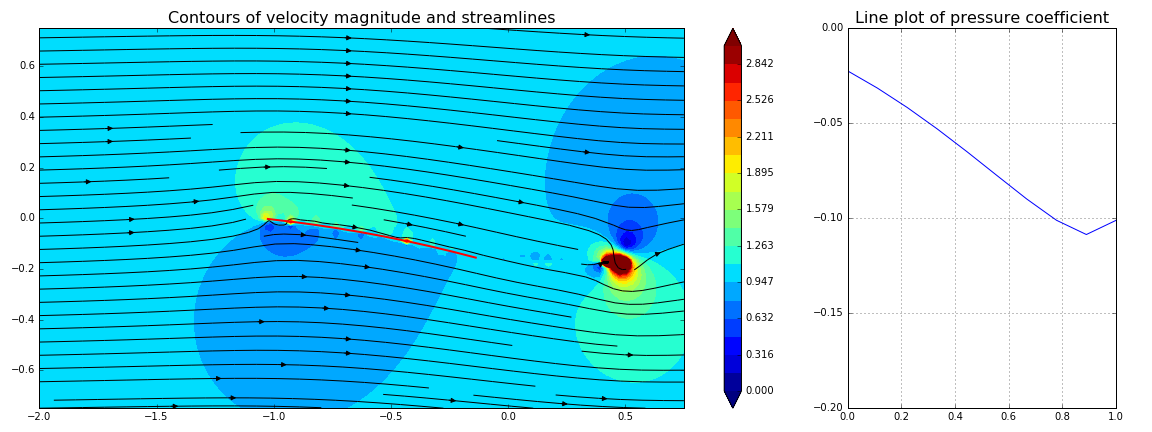
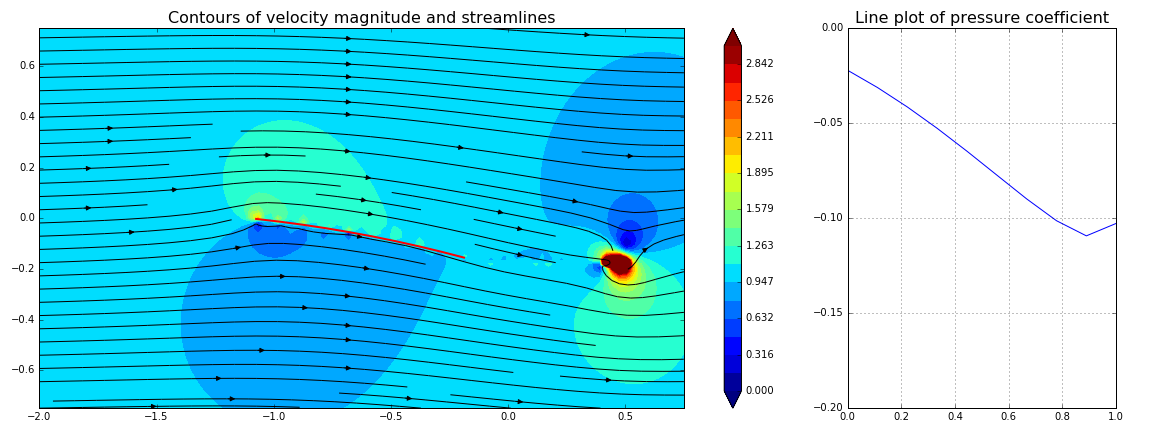
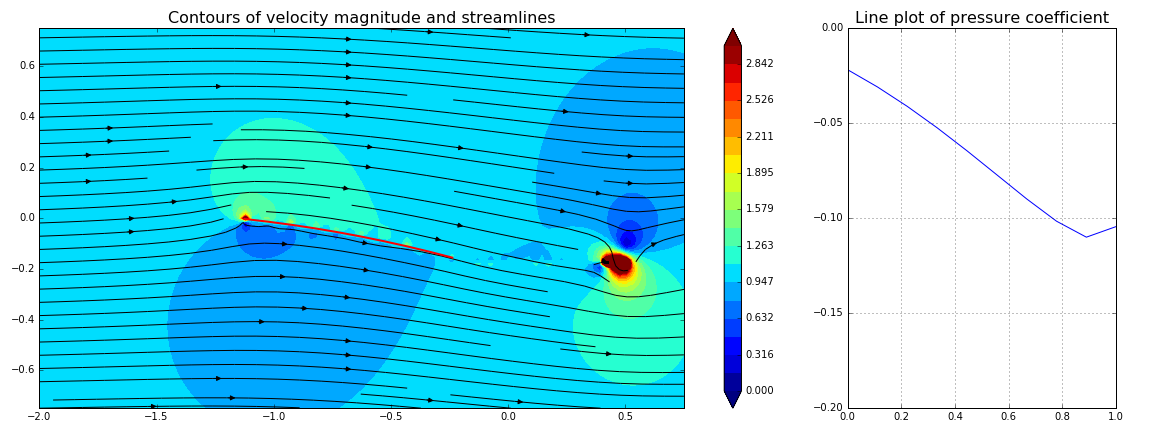
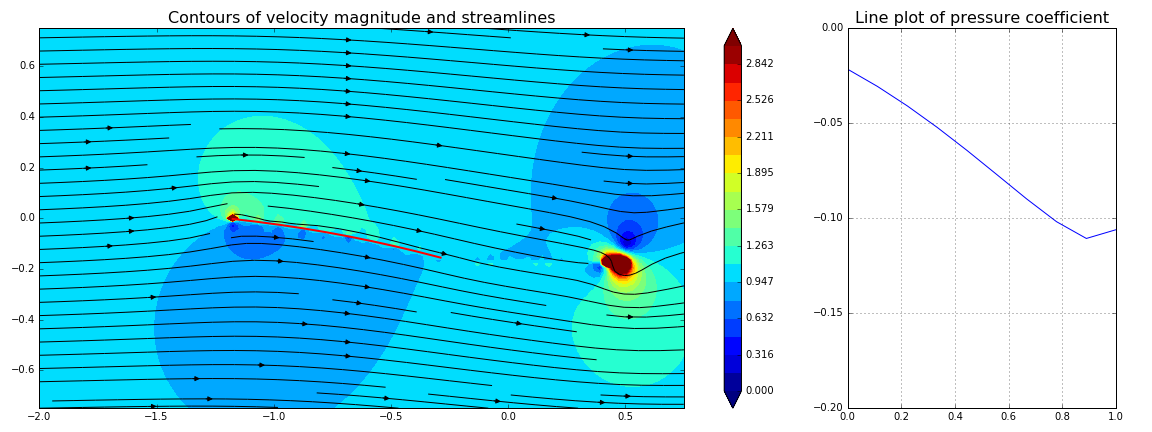
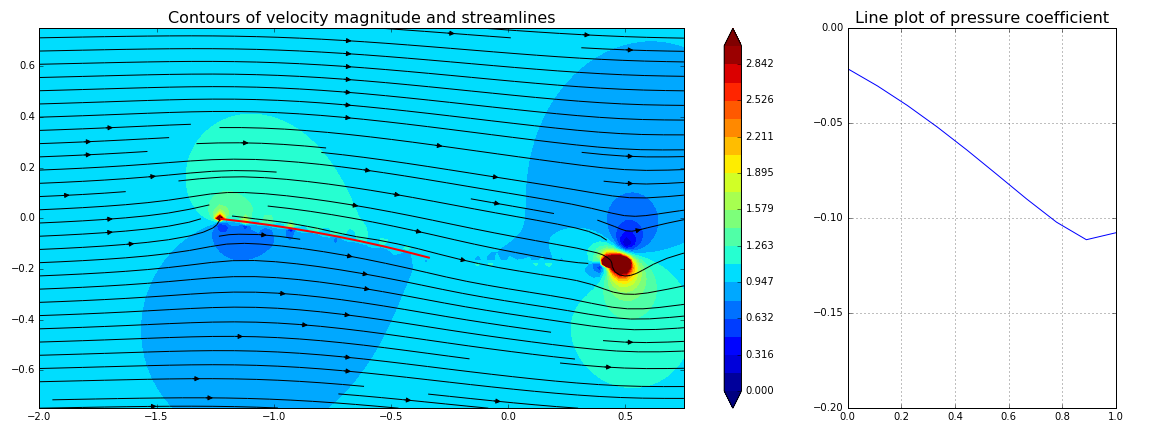
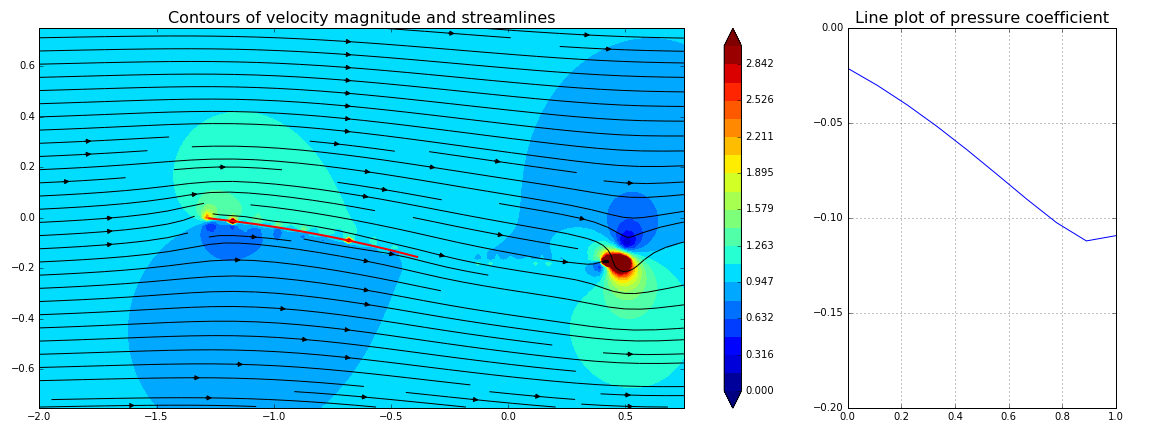
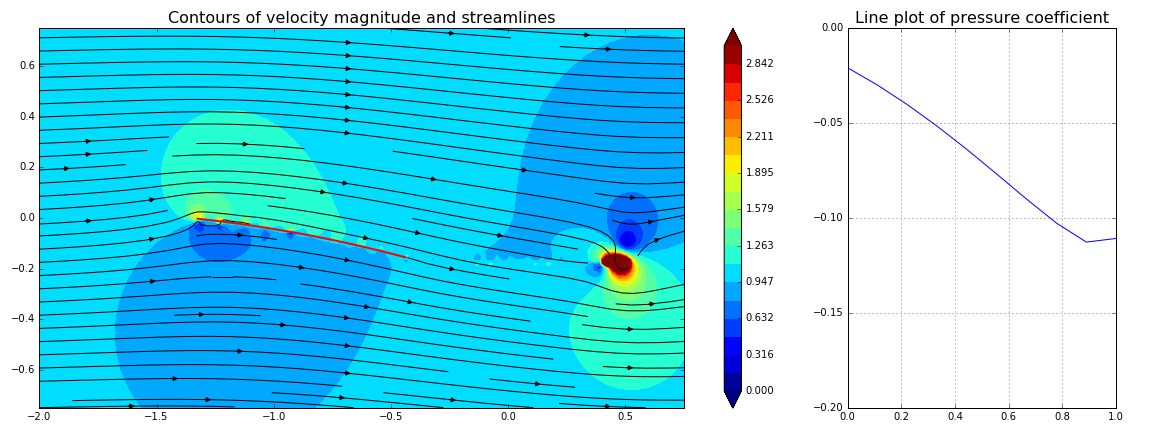
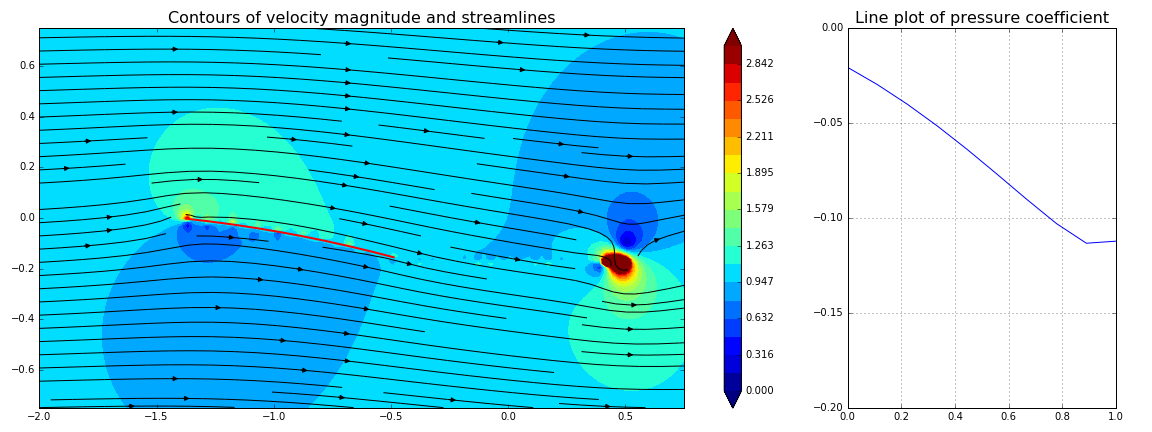
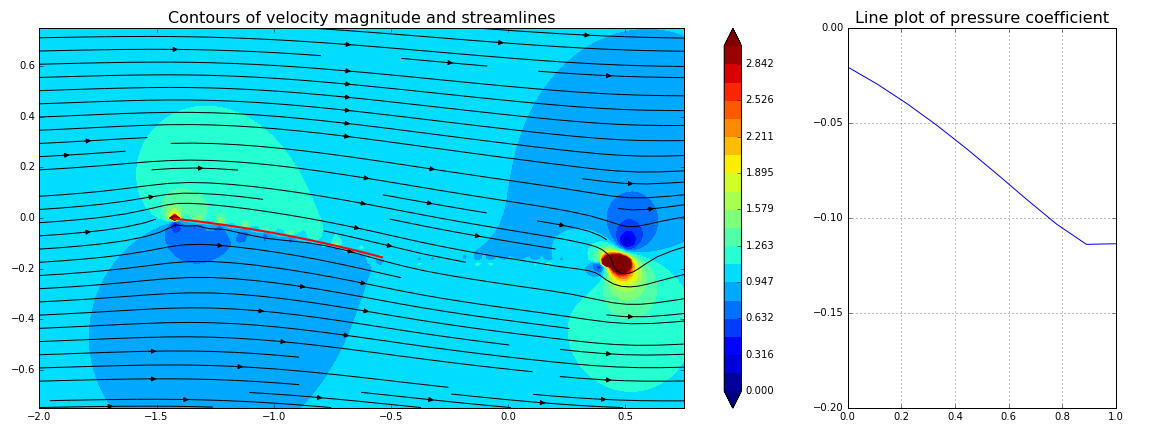
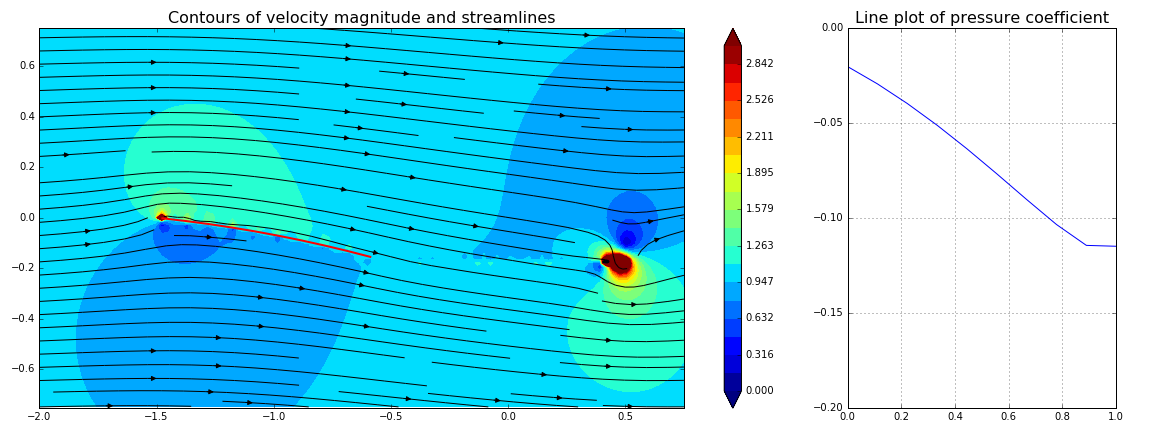

In [22]:
plot_vel = numpy.sqrt(uplot**2 + vplot**2)

create_contour_animation(ITERMAX, X, Y, uplot, vplot, plot_vel,  plot_Cp_data, plot_panels)